In [1]:
import numpy as np
import pandas as pd

import os
import glob

In [2]:
# %matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica Neue'], 
                 'serif': ['Helvetica Neue']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Generate plots of gating effects

In [56]:
test = pd.read_csv('../../Local Data/20181009 top 4 A B cell vars A=B flow samples/23hr/C4.csv')
test.columns

Index(['HDR-T', 'FSC-A', 'SSC-A', 'CFP/VioBlue-A', 'PE-A', 'mKate/APC-A',
       'GFP/FITC-A', 'AH_perc_gate', 'mKate/APC-A_GMMgate'],
      dtype='object')

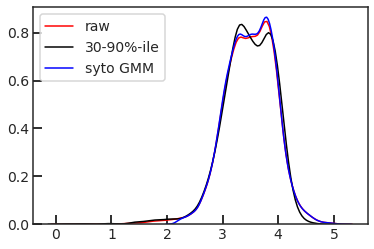

In [57]:
sns.kdeplot(test.loc[:, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['AH_perc_gate'] == 1, 'mKate/APC-A'].apply(np.log10))
sns.kdeplot(test.loc[test['mKate/APC-A_GMMgate'] == 1, 'mKate/APC-A'].apply(np.log10))

plt.legend(labels=['raw', '30-90%-ile', 'syto GMM'])

### This is a work in progress, wanted to check first to see what we got and then move forward with analysis

## Plot fractions on and off in YFP channel over time